In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
us_euro_uk_inr = pd.read_csv('Forex_data_preprocessed.csv',index_col=0)
us_euro_uk_inr.index = pd.DatetimeIndex(us_euro_uk_inr.index)
us_euro_uk_inr = us_euro_uk_inr.asfreq('b')
us_euro_uk_inr

,USD_EU,EU_GBP,INR_EU,EU_STOXX50,UK_FTSE100,US_SP500,INR_NIFTY50,Gold_USD,Crude_oil_USD
2000-01-03,1.0155,1.6022,44.2250,4849.22,6665.86,145.44,1592.20,282.7,25.55
2000-01-04,1.0309,1.5879,44.8957,4657.83,6665.86,139.75,1638.70,282.7,25.55
2000-01-05,1.0335,1.5883,45.0089,4541.75,6535.90,140.00,1595.80,281.1,24.91
2000-01-06,1.0324,1.5958,44.9610,4500.69,6447.24,137.75,1617.60,281.4,24.78
2000-01-07,1.0294,1.5916,44.8304,4648.27,6504.75,145.75,1613.30,281.9,24.22
...,...,...,...,...,...,...,...,...,...
2020-05-11,1.0818,1.1398,82.0762,2883.75,5939.73,292.50,9239.20,1698.0,24.14
2020-05-12,1.0864,1.1321,81.5126,2884.20,5994.77,286.67,9196.55,1706.8,25.78
2020-05-13,1.0837,1.1281,81.6351,2810.55,5904.05,281.60,9383.55,1716.4,25.29
2020-05-14,1.0800,1.1291,81.5184,2760.23,5741.54,284.97,9142.75,1740.9,27.56


In [3]:
us_euro_uk_inr_diff = us_euro_uk_inr.copy()
for col in us_euro_uk_inr_diff.columns:
    us_euro_uk_inr_diff[col] = us_euro_uk_inr_diff[col].diff()
    
us_euro_uk_inr_diff= us_euro_uk_inr_diff.dropna()

train = us_euro_uk_inr_diff[:-30]
test = us_euro_uk_inr_diff[-30:]


In [4]:
def get_diff(df,lookback): 
    x,y = [],[]
    history = list(range(lookback))
    history.reverse()
    op_columns = [cols +'_L'+str(lag+1) for cols in df.columns for lag in history ]
    for time in range(lookback,len(df)):
        x_tmp = []
        for col in range(len(df.columns)):
            if col ==0:
                x_tmp = list(df.iloc[:,col][time-lookback:time].values)
            else:
                x_tmp.extend(list(df.iloc[:,col][time-lookback:time].values))
        x.append(x_tmp)
    return pd.DataFrame(np.array(x),columns=op_columns)


exog = get_diff(us_euro_uk_inr_diff[['INR_NIFTY50','Gold_USD']],5)

# Gold =  3 lag & NIFTY = 5 lag
exog = exog[['INR_NIFTY50_L5', 'INR_NIFTY50_L4', 'INR_NIFTY50_L3', 'INR_NIFTY50_L2',
       'INR_NIFTY50_L1','Gold_USD_L3',
       'Gold_USD_L2', 'Gold_USD_L1']]

train = us_euro_uk_inr_diff[5:-30]
test = us_euro_uk_inr_diff[-30:]

train_exog = exog[:-30]
test_exog = exog[-30:]

train_exog.index = train.index
test_exog.index = test.index

exog

,INR_NIFTY50_L5,INR_NIFTY50_L4,INR_NIFTY50_L3,INR_NIFTY50_L2,INR_NIFTY50_L1,Gold_USD_L3,Gold_USD_L2,Gold_USD_L1
0,46.50,-42.90,21.80,-4.30,19.65,0.3,0.5,-0.2
1,-42.90,21.80,-4.30,19.65,-60.45,0.5,-0.2,1.7
2,21.80,-4.30,19.65,-60.45,52.30,-0.2,1.7,-0.7
3,-4.30,19.65,-60.45,52.30,-3.40,1.7,-0.7,1.4
4,19.65,-60.45,52.30,-3.40,1.35,-0.7,1.4,-0.2
...,...,...,...,...,...,...,...,...
5304,0.00,-87.90,65.30,-71.85,52.45,-22.1,37.3,-11.9
5305,-87.90,65.30,-71.85,52.45,-12.30,37.3,-11.9,-15.9
5306,65.30,-71.85,52.45,-12.30,-42.65,-11.9,-15.9,8.8
5307,-71.85,52.45,-12.30,-42.65,187.00,-15.9,8.8,9.6


In [5]:
def get_diff(df,lookback):
    x,y,col_name = [],[],[]
    for col in lookback.keys():
        lags = list(range(lookback[col]))
        lags.reverse()
        col_name.extend([col +'_L'+str(lag+1) for lag in lags])
    for col in lookback.keys():
        x_tmp = []
        for time in range(lookback[col],len(df)):
            if x_tmp ==[]:
                x_tmp = np.array([list(df[col][time-lookback[col]:time].values)])
            else:
                x_tmp = np.append(x_tmp,np.array([list(df[col][time-lookback[col]:time].values)]),axis=0)
        x.append(x_tmp)
    
    min_row = min([i.shape[0] for i in x])
    op = x[0][-min_row:,:]
    for item in x[1:]:
        op = np.append(op,item[-min_row:,:],axis =1)
        
    return pd.DataFrame(op,columns=col_name)

## INR_EU

1)ARDL

INR_EU

In [7]:

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


parm_dict = {}
aic=[]
for p in range(1,6):
    for d in range(1,6):
        x = get_diff(us_euro_uk_inr_diff[['INR_EU','INR_NIFTY50','Gold_USD']],{'INR_EU':p,'INR_NIFTY50':d,'Gold_USD':d})
        id = max(p,d)    
        train = us_euro_uk_inr_diff[id:-30]
        test = us_euro_uk_inr_diff[-30:]
        train_exog = x[:-30]
        test_exog = x[-30:]
        train_exog.index = train.index
        test_exog.index = test.index
        model = sm.OLS(us_euro_uk_inr_diff[id:-30].INR_EU, sm.add_constant(train_exog))
        results = model.fit()
        aic.append(results.rsquared_adj)
        parm_dict[(p,d)]=results.rsquared_adj

list(parm_dict.keys())[aic.index(max(aic))]


(5, 5)

In [52]:
x = get_diff(us_euro_uk_inr_diff[['INR_EU','INR_NIFTY50','Gold_USD']],{'INR_EU':5,'INR_NIFTY50':5,'Gold_USD':5})

train = us_euro_uk_inr_diff[5:-30]
test = us_euro_uk_inr_diff[-30:]

train_exog = x[:-30]
test_exog = x[-30:]

train_exog.index = train.index
test_exog.index = test.index

S:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


In [53]:
import statsmodels.api as sm

model = sm.OLS(us_euro_uk_inr_diff[5:-30].INR_EU, sm.add_constant(train_exog))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 INR_EU   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.266
Date:                Sun, 16 Aug 2020   Prob (F-statistic):           1.87e-05
Time:                        00:15:37   Log-Likelihood:                -2927.9
No. Observations:                5279   AIC:                             5888.
Df Residuals:                    5263   BIC:                             5993.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0077      0.006      1.

In [54]:
def get_price_from_diff(index,value):
    return us_euro_uk_inr.INR_EU[index-1]+value

forecast_prices = []
for index,forecast in enumerate(results.predict(sm.add_constant(test_exog))):
    if index == 0:
        forecast_prices.append(get_price_from_diff(index - 30,forecast))
    else:
        forecast_prices.append(forecast_prices[len(forecast_prices)-1]+forecast)
ardl_forecast = forecast_prices

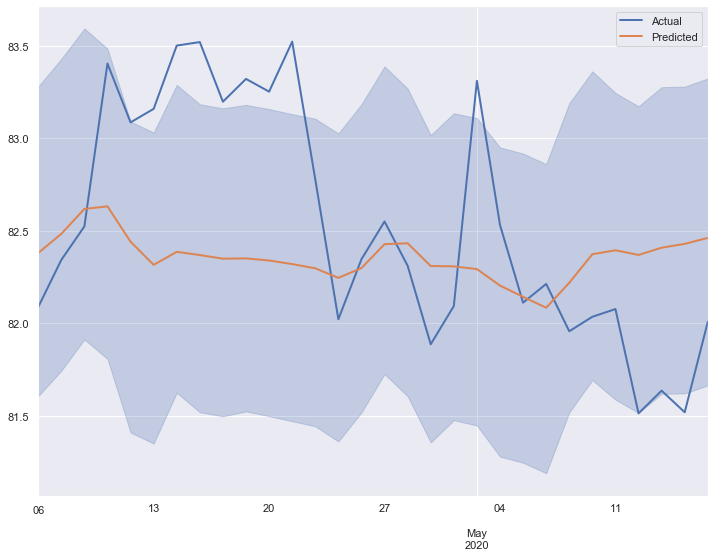

In [56]:

from statsmodels.sandbox.regression.predstd import wls_prediction_std
ci = wls_prediction_std(results, exog=sm.add_constant(test_exog), weights=None, alpha=0.05)
uci = np.array(ardl_forecast) + ci[2] 
lci = np.array(ardl_forecast) + ci[1] 

pd.DataFrame({'Actual':us_euro_uk_inr[-30:].INR_EU,'Predicted':ardl_forecast}).plot(figsize=(12,9),lw=2)
plt.fill_between( us_euro_uk_inr[-30:].index, uci, lci, color='b', alpha=.25)


In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)*100)

from sklearn.metrics import mean_squared_error

def get_metrics(weeks,actual,pred):
    print('{} weeks forecast metrics'.format(weeks))
    span = 7*weeks
    error = mean_squared_error(actual[:span], pred[:span])
    print('Test RMSE: {}'.format(np.sqrt(error)))
    print('Test MAPE: {}\n'.format(mean_absolute_percentage_error(actual[:span], pred[:span])))

pred = forecast_prices
ardl_inr_forecast = ardl_forecast[-30:]
get_metrics(2,us_euro_uk_inr.INR_EU[-30:],ardl_forecast[-30:])
get_metrics(4,us_euro_uk_inr.INR_EU[-30:],ardl_forecast[-30:])

2 weeks forecast metrics
Test RMSE: 0.8171184087486905
Test MAPE: 0.8653163343136924

4 weeks forecast metrics
Test RMSE: 0.6629715872687538
Test MAPE: 0.6433632262145453



2) LSTM

In [13]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import pandas as pd
import numpy as np

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))

USD_EU_diff = us_euro_uk_inr[['INR_EU','Gold_USD','Crude_oil_USD','INR_NIFTY50','INR_ema15']].values

USD_EU_scaled = scaler.fit_transform(USD_EU_diff)

USD_EU_scaled = pd.DataFrame(USD_EU_scaled)

def get_timeseries_lookback(df,lookback):
    x,y = [],[]
    for time in range(lookback,len(df)):
        x_tmp,y_tmp =[],[]
        for col in range(len(df.columns)):
            if col ==0:
                x_tmp = df.iloc[:,col][time-lookback:time].values.reshape(1,lookback)
                y_tmp = [df.iloc[:,col][time]]
            else:
                sec_arry = df.iloc[:,col][time-lookback:time].values.reshape(1,lookback)
                x_tmp = np.append(x_tmp,sec_arry,axis = 0)
                #y_tmp.append(df.iloc[:,col][time])
        x_tmp= np.dstack(x_tmp).reshape(1,lookback,len(df.columns))
        x.append(x_tmp)
        y.append(y_tmp)
    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[2],x.shape[3])
    return x,np.array(y)

x,y = get_timeseries_lookback(USD_EU_scaled,lookback = 5)

In [16]:
                                            
#x = x.reshape(x.shape[0],x.shape[1],1)
y = y.reshape(y.shape[0],)

train_x,test_x = x[:-30],x[-30:]
train_y,test_y = y[:-30],y[-30:]

print(train_x.shape,test_y.shape)

(5251, 5, 5) (30,)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# define model
reset_random_seeds()
model = Sequential()
model.add(LSTM(64,input_shape=(5, 5)))
model.add(Dropout(0.10))
model.add(Dense(1))
opt = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=opt, loss='mse')

model_history = model.fit(train_x,train_y,epochs=250,verbose=2,batch_size=30,validation_data=(test_x, test_y),shuffle=False)

Train on 5251 samples, validate on 30 samples
Epoch 1/250
5251/5251 - 4s - loss: 0.0055 - val_loss: 0.0015
Epoch 2/250
5251/5251 - 0s - loss: 0.0082 - val_loss: 9.2712e-04
Epoch 3/250
5251/5251 - 0s - loss: 0.0051 - val_loss: 0.0017
Epoch 4/250
5251/5251 - 0s - loss: 0.0034 - val_loss: 5.6127e-04
Epoch 5/250
5251/5251 - 0s - loss: 0.0028 - val_loss: 5.8325e-04
Epoch 6/250
5251/5251 - 0s - loss: 0.0025 - val_loss: 5.8502e-04
Epoch 7/250
5251/5251 - 0s - loss: 0.0023 - val_loss: 7.9042e-04
Epoch 8/250
5251/5251 - 0s - loss: 0.0021 - val_loss: 6.7688e-04
Epoch 9/250
5251/5251 - 0s - loss: 0.0020 - val_loss: 2.7626e-04
Epoch 10/250
5251/5251 - 0s - loss: 0.0019 - val_loss: 4.0296e-04
Epoch 11/250
5251/5251 - 0s - loss: 0.0018 - val_loss: 2.4726e-04
Epoch 12/250
5251/5251 - 0s - loss: 0.0017 - val_loss: 1.0549e-04
Epoch 13/250
5251/5251 - 0s - loss: 0.0017 - val_loss: 1.1321e-04
Epoch 14/250
5251/5251 - 0s - loss: 0.0016 - val_loss: 1.1028e-04
Epoch 15/250
5251/5251 - 0s - loss: 0.0016 - va

Epoch 120/250
5251/5251 - 0s - loss: 6.1096e-04 - val_loss: 2.3731e-04
Epoch 121/250
5251/5251 - 0s - loss: 6.0915e-04 - val_loss: 1.2320e-04
Epoch 122/250
5251/5251 - 1s - loss: 6.1944e-04 - val_loss: 2.4492e-04
Epoch 123/250
5251/5251 - 1s - loss: 6.0384e-04 - val_loss: 1.1587e-04
Epoch 124/250
5251/5251 - 0s - loss: 5.6734e-04 - val_loss: 1.2797e-04
Epoch 125/250
5251/5251 - 0s - loss: 6.0708e-04 - val_loss: 1.2317e-04
Epoch 126/250
5251/5251 - 0s - loss: 6.0908e-04 - val_loss: 1.2428e-04
Epoch 127/250
5251/5251 - 1s - loss: 5.9834e-04 - val_loss: 1.3126e-04
Epoch 128/250
5251/5251 - 0s - loss: 6.0455e-04 - val_loss: 3.8575e-04
Epoch 129/250
5251/5251 - 0s - loss: 6.0728e-04 - val_loss: 2.5401e-04
Epoch 130/250
5251/5251 - 1s - loss: 5.9112e-04 - val_loss: 1.3806e-04
Epoch 131/250
5251/5251 - 0s - loss: 5.7477e-04 - val_loss: 3.1066e-04
Epoch 132/250
5251/5251 - 1s - loss: 5.8476e-04 - val_loss: 2.4898e-04
Epoch 133/250
5251/5251 - 1s - loss: 5.8818e-04 - val_loss: 1.0510e-04
Epoch 

Epoch 236/250
5251/5251 - 1s - loss: 4.6720e-04 - val_loss: 2.1142e-04
Epoch 237/250
5251/5251 - 1s - loss: 4.7433e-04 - val_loss: 2.2448e-04
Epoch 238/250
5251/5251 - 1s - loss: 4.6639e-04 - val_loss: 2.6687e-04
Epoch 239/250
5251/5251 - 1s - loss: 4.8083e-04 - val_loss: 1.4386e-04
Epoch 240/250
5251/5251 - 1s - loss: 4.7806e-04 - val_loss: 1.7482e-04
Epoch 241/250
5251/5251 - 1s - loss: 4.6219e-04 - val_loss: 1.3272e-04
Epoch 242/250
5251/5251 - 1s - loss: 4.5306e-04 - val_loss: 1.4695e-04
Epoch 243/250
5251/5251 - 1s - loss: 4.6621e-04 - val_loss: 1.2586e-04
Epoch 244/250
5251/5251 - 1s - loss: 4.6454e-04 - val_loss: 9.9216e-05
Epoch 245/250
5251/5251 - 1s - loss: 4.6617e-04 - val_loss: 1.6932e-04
Epoch 246/250
5251/5251 - 1s - loss: 4.7802e-04 - val_loss: 2.0875e-04
Epoch 247/250
5251/5251 - 1s - loss: 4.6878e-04 - val_loss: 1.3446e-04
Epoch 248/250
5251/5251 - 1s - loss: 4.7435e-04 - val_loss: 1.2316e-04
Epoch 249/250
5251/5251 - 1s - loss: 4.6551e-04 - val_loss: 1.2662e-04
Epoch 

Text(0.5, 0, 'Epoch')

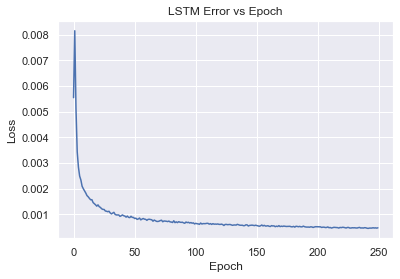

In [18]:
epochs = model_history.params['epochs']
loss = model_history.history['loss']

plt.plot(range(epochs),loss)
plt.title('LSTM Error vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [19]:
def get_price_from_diff(index,value):
    return us_euro_uk_inr.INR_EU[index-1]+value

In [20]:
pred = model.predict(test_x)
pred = np.hstack((pred,pred,pred,pred,pred)) # dummy columns to invert the transdorm and finally will discard the dummy column outputs
pred = scaler.inverse_transform(pred)

forecast_prices = pred[:,0]


fitted = model.predict(train_x)
fitted = np.hstack((fitted,fitted,fitted,fitted,fitted)) # dummy columns to invert the transdorm and finally will discard the dummy column outputs
fitted = scaler.inverse_transform(fitted)
fitted = fitted[:,0] 

Text(0.5, 1.0, 'LSTM Forecast for INR/EU Exchange Rates')

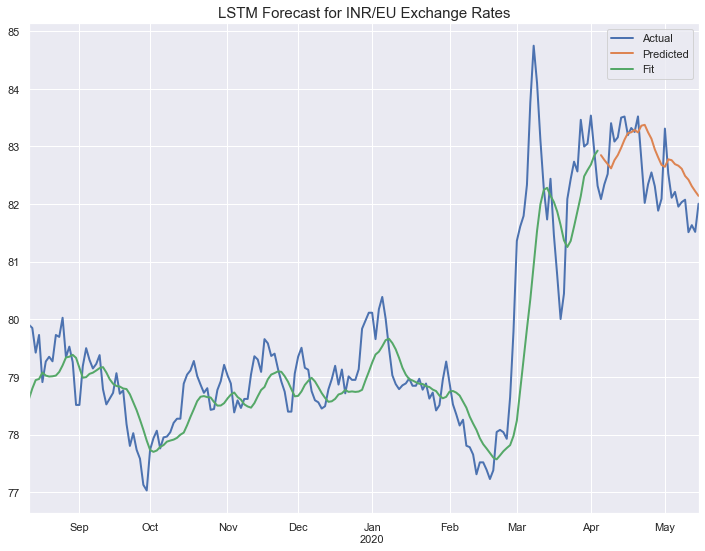

In [21]:

        
#fit =  np.append(arima_model.predict_in_sample(),np.repeat(np.nan,15, axis=0))[1:] # first value is zero since we did differencing
pred = np.append(np.repeat(np.nan,5251, axis=0),forecast_prices)
fitd = np.append(np.array(fitted),np.repeat(np.nan,30, axis=0))
forecast_df = pd.DataFrame({'Actual': us_euro_uk_inr.INR_EU[-200:],'Predicted' : pred[-200:], 'Fit':fitd[-200:]})
forecast_df.plot(figsize=(12,9),lw = 2)
plt.title('LSTM Forecast for INR/EU Exchange Rates',size=15)

Text(0.5, 1.0, 'LSTM Forecast Vs Actual INR/EU Exchange Rates')

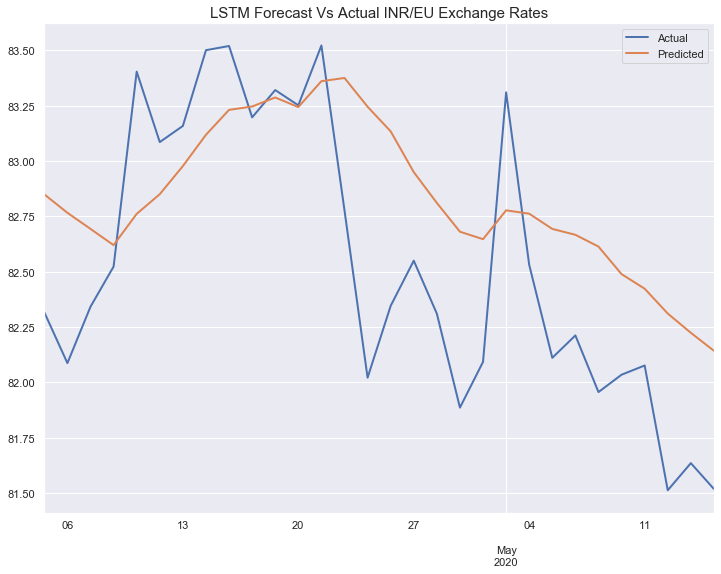

In [22]:
#fit =  np.append(arima_model.predict_in_sample(),np.repeat(np.nan,15, axis=0))[1:] # first value is zero since we did differencing
pred = np.append(np.repeat(np.nan,5251, axis=0),forecast_prices[-30:])
forecast_df = pd.DataFrame({'Actual': us_euro_uk_inr.INR_EU[-31:-1],'Predicted' : pred[-30:]})
forecast_df.plot(figsize=(12,9),lw=2)
plt.title('LSTM Forecast Vs Actual INR/EU Exchange Rates',size=15)

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)*100)

from sklearn.metrics import mean_squared_error

def get_metrics(weeks,actual,pred):
    print('{} weeks forecast metrics'.format(weeks))
    span = 7*weeks
    error = mean_squared_error(actual[:span], pred[:span])
    print('Test RMSE: {}'.format(np.sqrt(error)))
    print('Test MAPE: {}\n'.format(mean_absolute_percentage_error(actual[:span], pred[:span])))

pred = pred.reshape(1,-1)[0]
lstm_inr_forecast = pred[-30:]
get_metrics(2,us_euro_uk_inr.INR_EU[-30:],pred[-30:])
get_metrics(4,us_euro_uk_inr.INR_EU[-30:],pred[-30:])

2 weeks forecast metrics
Test RMSE: 0.5540595930295639
Test MAPE: 0.5227469539081059

4 weeks forecast metrics
Test RMSE: 0.6126112625581649
Test MAPE: 0.6511565411783635



In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [25]:
from scipy.stats import ttest_ind

ttest_ind(ardl_inr_forecast,lstm_inr_forecast)

Ttest_indResult(statistic=-7.649159940685885, pvalue=2.3764492350640157e-10)

## EU_GBP

1) ARDL

In [26]:

import warnings
warnings.filterwarnings('ignore')

'''
parm_dict = {}
aic=[]
for p in range(1,6):
    for d in range(1,6):
        x = get_diff(us_euro_uk_inr_diff[['EU_GBP','UK_FTSE100','EU_STOXX50']],{'EU_GBP':p,'UK_FTSE100':d,'EU_STOXX50':d})
        id = max(p,d)    
        train = us_euro_uk_inr_diff[id:-30]
        test = us_euro_uk_inr_diff[-30:]
        train_exog = x[:-30]
        test_exog = x[-30:]
        train_exog.index = train.index
        test_exog.index = test.index
        model = sm.OLS(us_euro_uk_inr_diff[id:-30].EU_GBP, sm.add_constant(train_exog))
        results = model.fit()
        aic.append(results.rsquared_adj)
        parm_dict[(p,d)]=results.rsquared_adj

list(parm_dict.keys())[aic.index(max(aic))]
'''

"\nparm_dict = {}\naic=[]\nfor p in range(1,6):\n    for d in range(1,6):\n        x = get_diff(us_euro_uk_inr_diff[['EU_GBP','UK_FTSE100','EU_STOXX50']],{'EU_GBP':p,'UK_FTSE100':d,'EU_STOXX50':d})\n        id = max(p,d)    \n        train = us_euro_uk_inr_diff[id:-30]\n        test = us_euro_uk_inr_diff[-30:]\n        train_exog = x[:-30]\n        test_exog = x[-30:]\n        train_exog.index = train.index\n        test_exog.index = test.index\n        model = sm.OLS(us_euro_uk_inr_diff[id:-30].EU_GBP, sm.add_constant(train_exog))\n        results = model.fit()\n        aic.append(results.rsquared_adj)\n        parm_dict[(p,d)]=results.rsquared_adj\n\nlist(parm_dict.keys())[aic.index(max(aic))]\n"

In [47]:
x = get_diff(us_euro_uk_inr_diff[['EU_GBP','UK_FTSE100','EU_STOXX50']],{'EU_GBP':5,'UK_FTSE100':3,'EU_STOXX50':3})

train = us_euro_uk_inr_diff[5:-30]
test = us_euro_uk_inr_diff[-30:]

train_exog = x[:-30]
test_exog = x[-30:]



S:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


In [48]:
train_exog.index = train.index
test_exog.index = test.index

In [49]:
import statsmodels.api as sm

model = sm.OLS(us_euro_uk_inr_diff[5:-30].EU_GBP, sm.add_constant(train_exog))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 EU_GBP   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.265
Date:                Sun, 16 Aug 2020   Prob (F-statistic):           0.000181
Time:                        00:15:04   Log-Likelihood:                 18998.
No. Observations:                5279   AIC:                        -3.797e+04
Df Residuals:                    5267   BIC:                        -3.789e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.627e-05   9.13e-05     -0.945

In [50]:
def get_price_from_diff(index,value):
    return us_euro_uk_inr.EU_GBP[index-1]+value

forecast_prices = []
for index,forecast in enumerate(results.predict(sm.add_constant(test_exog))):
    if index == 0:
        forecast_prices.append(get_price_from_diff(index - 30,forecast))
    else:
        forecast_prices.append(forecast_prices[len(forecast_prices)-1]+forecast)
ardl_forecast = forecast_prices

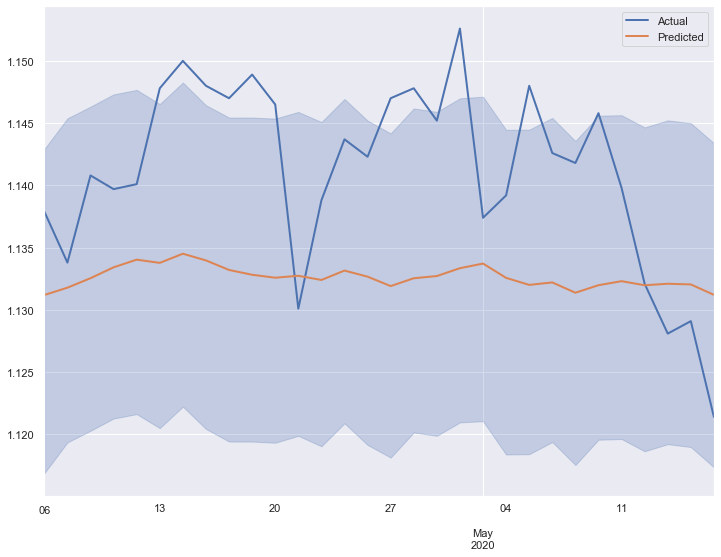

In [51]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
ci = wls_prediction_std(results, exog=sm.add_constant(test_exog), weights=None, alpha=0.05)
uci = np.array(ardl_forecast) + ci[2] 
lci = np.array(ardl_forecast) + ci[1] 

pd.DataFrame({'Actual':us_euro_uk_inr[-30:].EU_GBP,'Predicted':ardl_forecast}).plot(figsize=(12,9),lw=2)
plt.fill_between( us_euro_uk_inr[-30:].index, uci, lci, color='b', alpha=.25)



In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)*100)

from sklearn.metrics import mean_squared_error

def get_metrics(weeks,actual,pred):
    print('{} weeks forecast metrics'.format(weeks))
    span = 7*weeks
    error = mean_squared_error(actual[:span], pred[:span])
    print('Test RMSE: {}'.format(np.sqrt(error)))
    print('Test MAPE: {}\n'.format(mean_absolute_percentage_error(actual[:span], pred[:span])))

pred = forecast_prices
ardl_gbp_forecast = ardl_forecast[-30:]
get_metrics(2,us_euro_uk_inr.EU_GBP[-30:],ardl_forecast[-30:])
get_metrics(4,us_euro_uk_inr.EU_GBP[-30:],ardl_forecast[-30:])

2 weeks forecast metrics
Test RMSE: 0.010733847939095233
Test MAPE: 0.8453687171715408

4 weeks forecast metrics
Test RMSE: 0.011155790064198425
Test MAPE: 0.8722206415079329



2) LSTM

In [33]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import pandas as pd
import numpy as np

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [34]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

USD_EU_diff = us_euro_uk_inr[['EU_GBP','GBP_ema15','UK_FTSE100','EU_STOXX50']].values

USD_EU_scaled = scaler.fit_transform(USD_EU_diff)

USD_EU_scaled = pd.DataFrame(USD_EU_scaled)

def get_timeseries_lookback(df,lookback):
    x,y = [],[]
    for time in range(lookback,len(df)):
        x_tmp,y_tmp =[],[]
        for col in range(len(df.columns)):
            if col ==0:
                x_tmp = df.iloc[:,col][time-lookback:time].values.reshape(1,lookback)
                y_tmp = [df.iloc[:,col][time]]
            else:
                sec_arry = df.iloc[:,col][time-lookback+1:time+1].values.reshape(1,lookback)
                x_tmp = np.append(x_tmp,sec_arry,axis = 0)
                #y_tmp.append(df.iloc[:,col][time])
        x_tmp= np.dstack(x_tmp).reshape(1,lookback,len(df.columns))
        x.append(x_tmp)
        y.append(y_tmp)
    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[2],x.shape[3])
    return x,np.array(y)

x,y = get_timeseries_lookback(USD_EU_scaled,lookback = 5)

In [36]:
                                            
#x = x.reshape(x.shape[0],x.shape[1],1)
y = y.reshape(y.shape[0],y.shape[1],1)

train_x,test_x = x[:-30],x[-30:]
train_y,test_y = y[:-30],y[-30:]

print(train_x.shape,test_y.shape)

(5251, 5, 4) (30, 1, 1)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# define model
reset_random_seeds()
model = Sequential()
model.add(LSTM(64,input_shape=(5, 4)))
model.add(Dropout(0.10))
model.add(Dense(1))
opt = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=opt, loss='mse')

model_history = model.fit(train_x,train_y,epochs=100,verbose=2,batch_size=30,validation_data=(test_x, test_y),shuffle=False)

Train on 5251 samples, validate on 30 samples
Epoch 1/100
5251/5251 - 2s - loss: 0.0217 - val_loss: 1.6241e-04
Epoch 2/100
5251/5251 - 1s - loss: 0.0080 - val_loss: 1.9945e-04
Epoch 3/100
5251/5251 - 1s - loss: 0.0050 - val_loss: 2.5635e-04
Epoch 4/100
5251/5251 - 1s - loss: 0.0034 - val_loss: 2.6672e-04
Epoch 5/100
5251/5251 - 0s - loss: 0.0025 - val_loss: 2.1069e-04
Epoch 6/100
5251/5251 - 1s - loss: 0.0019 - val_loss: 1.7971e-04
Epoch 7/100
5251/5251 - 1s - loss: 0.0018 - val_loss: 1.5984e-04
Epoch 8/100
5251/5251 - 0s - loss: 0.0016 - val_loss: 1.3267e-04
Epoch 9/100
5251/5251 - 0s - loss: 0.0014 - val_loss: 1.2359e-04
Epoch 10/100
5251/5251 - 1s - loss: 0.0014 - val_loss: 1.0035e-04
Epoch 11/100
5251/5251 - 1s - loss: 0.0013 - val_loss: 9.8942e-05
Epoch 12/100
5251/5251 - 0s - loss: 0.0013 - val_loss: 9.5161e-05
Epoch 13/100
5251/5251 - 0s - loss: 0.0013 - val_loss: 9.4322e-05
Epoch 14/100
5251/5251 - 0s - loss: 0.0012 - val_loss: 9.8019e-05
Epoch 15/100
5251/5251 - 0s - loss: 0.0

Text(0.5, 0, 'Epoch')

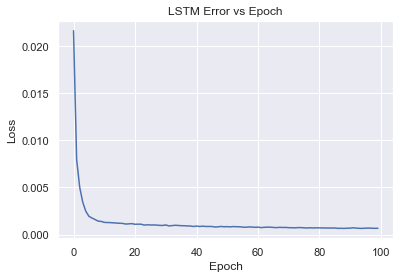

In [38]:
epochs = model_history.params['epochs']
loss = model_history.history['loss']

plt.plot(range(epochs),loss)
plt.title('LSTM Error vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [39]:
def get_price_from_diff(index,value):
    return us_euro_uk_inr.EU_GBP[index-1]+value

In [40]:
pred = model.predict(test_x)
pred = np.hstack((pred,pred,pred,pred)) # dummy columns to invert the transdorm and finally will discard the dummy column outputs
pred = scaler.inverse_transform(pred)

forecast_prices = pred[:,0]


fitted = model.predict(train_x)
fitted = np.hstack((fitted,fitted,fitted,fitted)) # dummy columns to invert the transdorm and finally will discard the dummy column outputs
fitted = scaler.inverse_transform(fitted)
fitted = fitted[:,0] 

Text(0.5, 1.0, 'LSTM Forecast for INR/EU Exchange Rates')

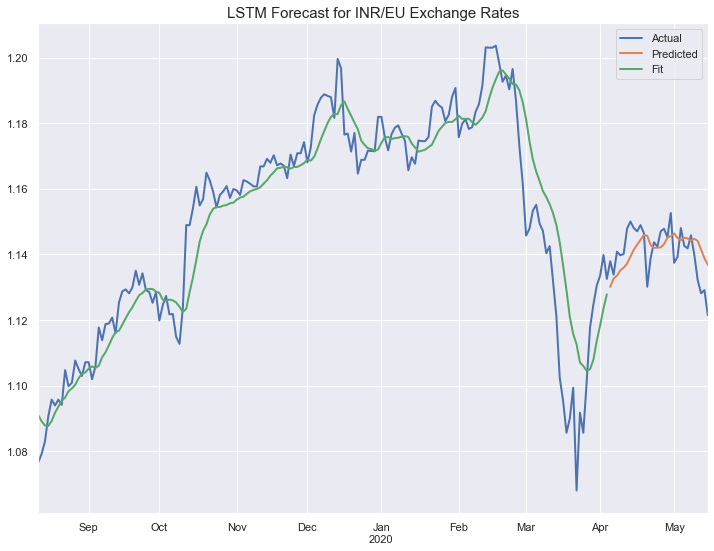

In [41]:

        
#fit =  np.append(arima_model.predict_in_sample(),np.repeat(np.nan,15, axis=0))[1:] # first value is zero since we did differencing
pred = np.append(np.repeat(np.nan,5251, axis=0),forecast_prices)
fitd = np.append(np.array(fitted),np.repeat(np.nan,30, axis=0))
forecast_df = pd.DataFrame({'Actual': us_euro_uk_inr.EU_GBP[-200:],'Predicted' : pred[-200:], 'Fit':fitd[-200:]})
forecast_df.plot(figsize=(12,9),lw = 2)
plt.title('LSTM Forecast for INR/EU Exchange Rates',size=15)

Text(0.5, 1.0, 'LSTM Forecast Vs Actual EU/GBP Exchange Rates')

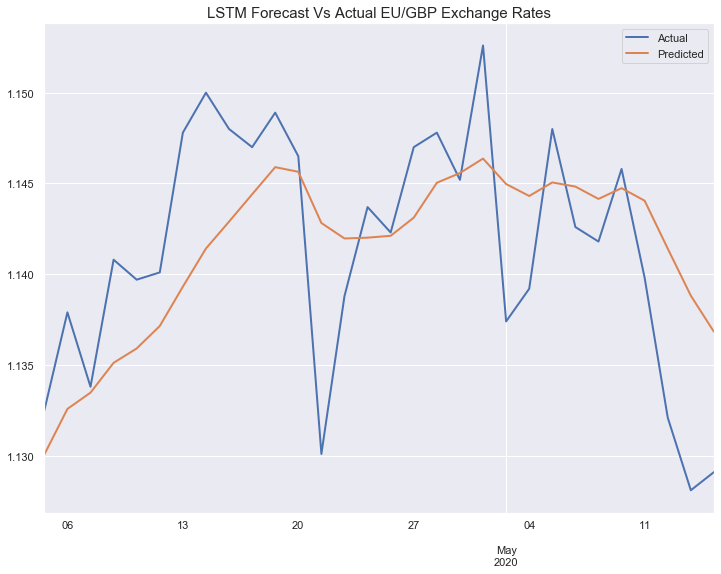

In [42]:
#fit =  np.append(arima_model.predict_in_sample(),np.repeat(np.nan,15, axis=0))[1:] # first value is zero since we did differencing
pred = np.append(np.repeat(np.nan,5251, axis=0),forecast_prices[-30:])
forecast_df = pd.DataFrame({'Actual': us_euro_uk_inr.EU_GBP[-31:-1],'Predicted' : pred[-30:]})
forecast_df.plot(figsize=(12,9),lw=2)
plt.title('LSTM Forecast Vs Actual EU/GBP Exchange Rates',size=15)

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)*100)

from sklearn.metrics import mean_squared_error

def get_metrics(weeks,actual,pred):
    print('{} weeks forecast metrics'.format(weeks))
    span = 7*weeks
    error = mean_squared_error(actual[:span], pred[:span])
    print('Test RMSE: {}'.format(np.sqrt(error)))
    print('Test MAPE: {}\n'.format(mean_absolute_percentage_error(actual[:span], pred[:span])))

pred = pred.reshape(1,-1)[0]
lstm_gbp_forecast = pred[-30:]
get_metrics(2,us_euro_uk_inr.EU_GBP[-30:],pred[-30:])
get_metrics(4,us_euro_uk_inr.EU_GBP[-30:],pred[-30:])

2 weeks forecast metrics
Test RMSE: 0.007191531571067717
Test MAPE: 0.5227720898980744

4 weeks forecast metrics
Test RMSE: 0.00683745332904778
Test MAPE: 0.4896902780260031



In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [45]:
from scipy.stats import ttest_ind

ttest_ind(ardl_gbp_forecast,lstm_gbp_forecast)

Ttest_indResult(statistic=-10.587838357320654, pvalue=3.581348782564153e-15)

## EU_USD

1) ADL

In [46]:

import warnings
warnings.filterwarnings('ignore')

'''
parm_dict = {}
aic=[]
for p in range(1,6):
    for d in range(1,6):
        x = get_diff(us_euro_uk_inr_diff[['USD_EU','Gold_USD','US_SP500','Crude_oil_USD']],{'USD_EU':p,'Gold_USD':d,'US_SP500':d,'Crude_oil_USD':d})
        id = max(p,d)    
        train = us_euro_uk_inr_diff[id:-30]
        test = us_euro_uk_inr_diff[-30:]
        train_exog = x[:-30]
        test_exog = x[-30:]
        train_exog.index = train.index
        test_exog.index = test.index
        model = sm.OLS(us_euro_uk_inr_diff[id:-30].USD_EU, sm.add_constant(train_exog))
        results = model.fit()
        aic.append(results.rsquared_adj)
        parm_dict[(p,d)]=results.rsquared_adj
        
list(parm_dict.keys())[aic.index(max(aic))]
'''

"\nparm_dict = {}\naic=[]\nfor p in range(1,6):\n    for d in range(1,6):\n        x = get_diff(us_euro_uk_inr_diff[['USD_EU','Gold_USD','US_SP500','Crude_oil_USD']],{'USD_EU':p,'Gold_USD':d,'US_SP500':d,'Crude_oil_USD':d})\n        id = max(p,d)    \n        train = us_euro_uk_inr_diff[id:-30]\n        test = us_euro_uk_inr_diff[-30:]\n        train_exog = x[:-30]\n        test_exog = x[-30:]\n        train_exog.index = train.index\n        test_exog.index = test.index\n        model = sm.OLS(us_euro_uk_inr_diff[id:-30].USD_EU, sm.add_constant(train_exog))\n        results = model.fit()\n        aic.append(results.rsquared_adj)\n        parm_dict[(p,d)]=results.rsquared_adj\n        \nlist(parm_dict.keys())[aic.index(max(aic))]\n"

In [40]:
x = get_diff(us_euro_uk_inr_diff[['USD_EU','Gold_USD','US_SP500','Crude_oil_USD']],{'USD_EU':2,'Gold_USD':4,'US_SP500':4,'Crude_oil_USD':4})

train = us_euro_uk_inr_diff[4:-30]
test = us_euro_uk_inr_diff[-30:]

train_exog = x[:-30]
test_exog = x[-30:]



S:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


In [41]:
train_exog.index = train.index
test_exog.index = test.index

In [42]:
import statsmodels.api as sm

model = sm.OLS(us_euro_uk_inr_diff[4:-30].USD_EU, sm.add_constant(train_exog))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 USD_EU   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.691
Date:                Sat, 15 Aug 2020   Prob (F-statistic):           3.45e-06
Time:                        22:04:20   Log-Likelihood:                 18530.
No. Observations:                5280   AIC:                        -3.703e+04
Df Residuals:                    5265   BIC:                        -3.693e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -5.27e-06   9.99e-05  

In [43]:
def get_price_from_diff(index,value):
    return us_euro_uk_inr.USD_EU[index-1]+value

forecast_prices = []
for index,forecast in enumerate(results.predict(sm.add_constant(test_exog))):
    if index == 0:
        forecast_prices.append(get_price_from_diff(index - 30,forecast))
    else:
        forecast_prices.append(forecast_prices[len(forecast_prices)-1]+forecast)
ardl_forecast = forecast_prices

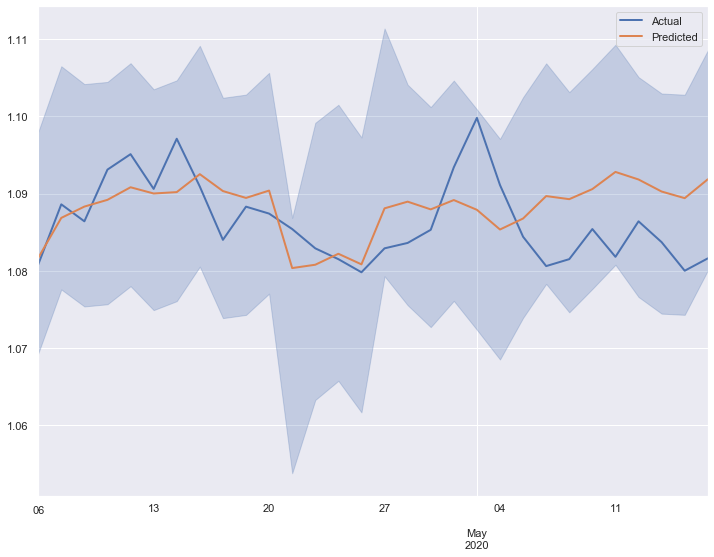

In [46]:

from statsmodels.sandbox.regression.predstd import wls_prediction_std
ci = wls_prediction_std(results, exog=sm.add_constant(test_exog), weights=None, alpha=0.05)
uci = np.array(ardl_forecast) + ci[2] 
lci = np.array(ardl_forecast) + ci[1] 

pd.DataFrame({'Actual':us_euro_uk_inr[-30:].USD_EU,'Predicted':ardl_forecast}).plot(figsize=(12,9),lw=2)
plt.fill_between( us_euro_uk_inr[-30:].index, uci, lci, color='b', alpha=.25)


In [45]:
np.array([[1,2,34]]).reshape(3,)

array([ 1,  2, 34])

In [53]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)*100)

from sklearn.metrics import mean_squared_error

def get_metrics(weeks,actual,pred):
    print('{} weeks forecast metrics'.format(weeks))
    span = 7*weeks
    error = mean_squared_error(actual[:span], pred[:span])
    print('Test RMSE: {}'.format(np.sqrt(error)))
    print('Test MAPE: {}\n'.format(mean_absolute_percentage_error(actual[:span], pred[:span])))

pred = forecast_prices
ardl_usd_forecast = ardl_forecast[-30:]
get_metrics(2,us_euro_uk_inr.USD_EU[-30:],ardl_forecast[-30:])
get_metrics(4,us_euro_uk_inr.USD_EU[-30:],ardl_forecast[-30:])

2 weeks forecast metrics
Test RMSE: 0.0035597343130959296
Test MAPE: 0.26439567790574775

4 weeks forecast metrics
Test RMSE: 0.005331881279055803
Test MAPE: 0.4032168577445739



2) LSTM

In [54]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import pandas as pd
import numpy as np

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [55]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

USD_EU_diff = us_euro_uk_inr[['USD_EU','US_SP500','Gold_USD','Crude_oil_USD']].values

USD_EU_scaled = scaler.fit_transform(USD_EU_diff)

USD_EU_scaled = pd.DataFrame(USD_EU_scaled)

def get_timeseries_lookback(df,lookback):
    x,y = [],[]
    for time in range(lookback,len(df)):
        x_tmp,y_tmp =[],[]
        for col in range(len(df.columns)):
            if col ==0:
                x_tmp = df.iloc[:,col][time-lookback:time].values.reshape(1,lookback)
                y_tmp = [df.iloc[:,col][time]]
            else:
                sec_arry = df.iloc[:,col][time-lookback+1:time+1].values.reshape(1,lookback)
                x_tmp = np.append(x_tmp,sec_arry,axis = 0)
                #y_tmp.append(df.iloc[:,col][time])
        x_tmp= np.dstack(x_tmp).reshape(1,lookback,len(df.columns))
        x.append(x_tmp)
        y.append(y_tmp)
    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[2],x.shape[3])
    return x,np.array(y)

x,y = get_timeseries_lookback(USD_EU_scaled,lookback = 5)

In [57]:
                                            
#x = x.reshape(x.shape[0],x.shape[1],1)
y = y.reshape(y.shape[0],y.shape[1],1)

train_x,test_x = x[:-30],x[-30:]
train_y,test_y = y[:-30],y[-30:]

print(train_x.shape,test_y.shape)

(5251, 5, 4) (30, 1, 1)


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# define model
reset_random_seeds()
model = Sequential()
model.add(LSTM(64,input_shape=(5, 4)))
model.add(Dropout(0.10))
model.add(Dense(1))
opt = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=opt, loss='mse')

model_history = model.fit(train_x,train_y,epochs=150,verbose=2,batch_size=30,validation_data=(test_x, test_y),shuffle=False)

Train on 5251 samples, validate on 30 samples
Epoch 1/150
5251/5251 - 2s - loss: 0.0150 - val_loss: 6.4698e-04
Epoch 2/150
5251/5251 - 1s - loss: 0.0115 - val_loss: 3.1607e-04
Epoch 3/150
5251/5251 - 1s - loss: 0.0102 - val_loss: 8.4476e-05
Epoch 4/150
5251/5251 - 1s - loss: 0.0088 - val_loss: 2.1686e-04
Epoch 5/150
5251/5251 - 1s - loss: 0.0076 - val_loss: 2.8386e-04
Epoch 6/150
5251/5251 - 1s - loss: 0.0067 - val_loss: 6.3113e-04
Epoch 7/150
5251/5251 - 1s - loss: 0.0057 - val_loss: 7.2831e-04
Epoch 8/150
5251/5251 - 0s - loss: 0.0048 - val_loss: 9.7871e-04
Epoch 9/150
5251/5251 - 1s - loss: 0.0041 - val_loss: 0.0013
Epoch 10/150
5251/5251 - 1s - loss: 0.0034 - val_loss: 0.0011
Epoch 11/150
5251/5251 - 1s - loss: 0.0029 - val_loss: 0.0013
Epoch 12/150
5251/5251 - 1s - loss: 0.0025 - val_loss: 0.0013
Epoch 13/150
5251/5251 - 1s - loss: 0.0022 - val_loss: 0.0010
Epoch 14/150
5251/5251 - 1s - loss: 0.0020 - val_loss: 0.0012
Epoch 15/150
5251/5251 - 1s - loss: 0.0018 - val_loss: 6.7807e-

Epoch 120/150
5251/5251 - 1s - loss: 5.5448e-04 - val_loss: 9.2294e-05
Epoch 121/150
5251/5251 - 1s - loss: 5.6013e-04 - val_loss: 9.2111e-05
Epoch 122/150
5251/5251 - 1s - loss: 5.7379e-04 - val_loss: 6.3439e-05
Epoch 123/150
5251/5251 - 1s - loss: 5.2634e-04 - val_loss: 6.4855e-05
Epoch 124/150
5251/5251 - 1s - loss: 5.5916e-04 - val_loss: 5.4436e-05
Epoch 125/150
5251/5251 - 1s - loss: 5.4386e-04 - val_loss: 5.5236e-05
Epoch 126/150
5251/5251 - 1s - loss: 5.6299e-04 - val_loss: 8.3201e-05
Epoch 127/150
5251/5251 - 1s - loss: 5.2662e-04 - val_loss: 5.3666e-05
Epoch 128/150
5251/5251 - 1s - loss: 5.4179e-04 - val_loss: 5.4845e-05
Epoch 129/150
5251/5251 - 1s - loss: 5.3582e-04 - val_loss: 5.4133e-05
Epoch 130/150
5251/5251 - 1s - loss: 5.4144e-04 - val_loss: 6.9345e-05
Epoch 131/150
5251/5251 - 1s - loss: 5.3537e-04 - val_loss: 8.4405e-05
Epoch 132/150
5251/5251 - 1s - loss: 5.4316e-04 - val_loss: 7.6759e-05
Epoch 133/150
5251/5251 - 1s - loss: 5.3887e-04 - val_loss: 5.3788e-05
Epoch 

Text(0.5, 0, 'Epoch')

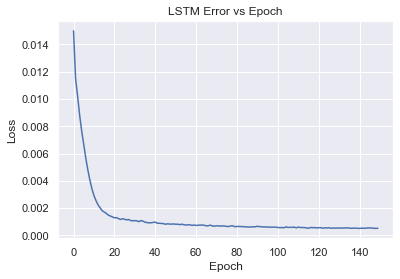

In [59]:
epochs = model_history.params['epochs']
loss = model_history.history['loss']

plt.plot(range(epochs),loss)
plt.title('LSTM Error vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [60]:
def get_price_from_diff(index,value):
    return us_euro_uk_inr.USD_EU[index-1]+value

In [61]:
pred = model.predict(test_x)
pred = np.hstack((pred,pred,pred,pred)) # dummy columns to invert the transdorm and finally will discard the dummy column outputs
pred = scaler.inverse_transform(pred)

forecast_prices = pred[:,0]


fitted = model.predict(train_x)
fitted = np.hstack((fitted,fitted,fitted,fitted)) # dummy columns to invert the transdorm and finally will discard the dummy column outputs
fitted = scaler.inverse_transform(fitted)
fitted = fitted[:,0] 

Text(0.5, 1.0, 'LSTM Forecast for INR/EU Exchange Rates')

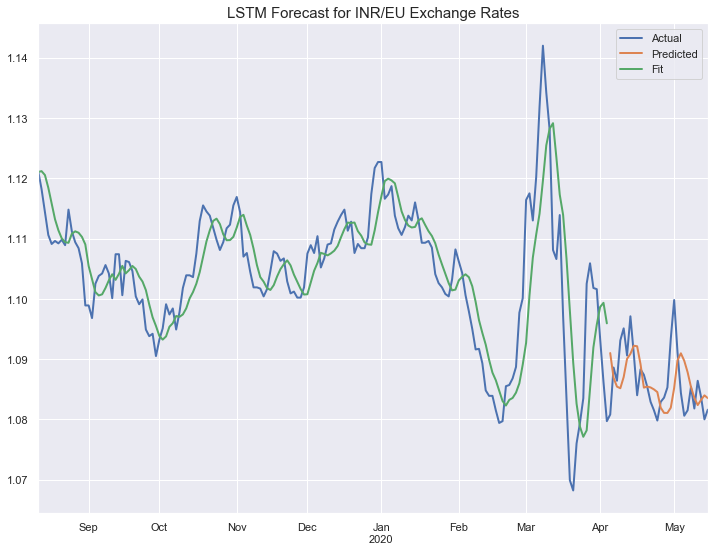

In [62]:

        
#fit =  np.append(arima_model.predict_in_sample(),np.repeat(np.nan,15, axis=0))[1:] # first value is zero since we did differencing
pred = np.append(np.repeat(np.nan,5251, axis=0),forecast_prices)
fitd = np.append(np.array(fitted),np.repeat(np.nan,30, axis=0))
forecast_df = pd.DataFrame({'Actual': us_euro_uk_inr.USD_EU[-200:],'Predicted' : pred[-200:], 'Fit':fitd[-200:]})
forecast_df.plot(figsize=(12,9),lw = 2)
plt.title('LSTM Forecast for INR/EU Exchange Rates',size=15)

Text(0.5, 1.0, 'LSTM Forecast Vs Actual USD/EU Exchange Rates')

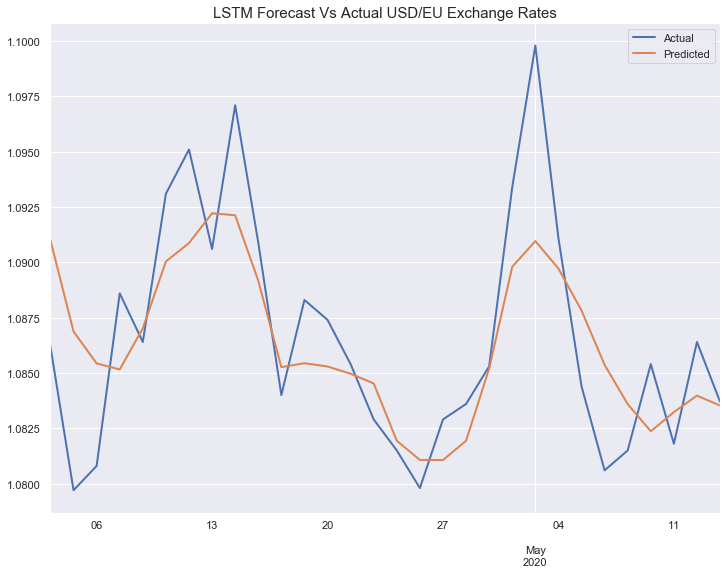

In [63]:
#fit =  np.append(arima_model.predict_in_sample(),np.repeat(np.nan,15, axis=0))[1:] # first value is zero since we did differencing
pred = np.append(np.repeat(np.nan,5251, axis=0),forecast_prices[-30:])
forecast_df = pd.DataFrame({'Actual': us_euro_uk_inr.USD_EU[-32:-2],'Predicted' : pred[-30:]})
forecast_df.plot(figsize=(12,9),lw=2)
plt.title('LSTM Forecast Vs Actual USD/EU Exchange Rates',size=15)

In [64]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)*100)

from sklearn.metrics import mean_squared_error

def get_metrics(weeks,actual,pred):
    print('{} weeks forecast metrics'.format(weeks))
    span = 7*weeks
    error = mean_squared_error(actual[:span], pred[:span])
    print('Test RMSE: {}'.format(np.sqrt(error)))
    print('Test MAPE: {}\n'.format(mean_absolute_percentage_error(actual[:span], pred[:span])))

pred = pred.reshape(1,-1)[0]
lstm_usd_forecast = pred[-30:]
get_metrics(2,us_euro_uk_inr.USD_EU[-30:],pred[-30:])
get_metrics(4,us_euro_uk_inr.USD_EU[-30:],pred[-30:])

2 weeks forecast metrics
Test RMSE: 0.005114952879922898
Test MAPE: 0.35480689768101553

4 weeks forecast metrics
Test RMSE: 0.005812886081454822
Test MAPE: 0.401073261392696



In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [66]:
from scipy.stats import ttest_ind

ttest_ind(ardl_usd_forecast,lstm_usd_forecast)

Ttest_indResult(statistic=1.8870826222763837, pvalue=0.0641570950025243)

## --------------------------------------------------------------------------------------------------------